In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import sys
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# add workspace directory to the path so we
# can import from .py files there 
sys.path.insert(1, '/data/workspace_files/')
from models import GridSearch, EWMAModel

sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
SENT_DIR = '/data/workspace_files/RoBERTa Sentiment Scores'
DATA_DIR = '/data/workspace_files/BTC and ETH Price Data'
COUNT_DIR = '/data/workspace_files/Tweet Counts'
OUTPUT_DIR = '/data/workspace_files'

### Sentiment Indices and Dataset Compilation

In this notebook, we use the sentiment scores from the RoBERTa model (see the **RoBERTa Sentiment Scoring** notebook) to create sentiment indices using the Random Tweet and Top 100 datasets. After, we compile the indices and other data into a comprehensive dataset that we use for our empirical analyses. The indices are creased as exponentially weighted moving averages (EWMA) of the tweet scores, and the EWMA $\alpha$ parameter is determined via a simple grid search. 

First we define some helper functions for loading data and evaluating the indices during the grid search.

In [3]:
def ewma_eval(model, y=None, x=None):
    """Evaluation function for grid search for the EWMA model."""
    # calculate ewma of the series
    x = model.predict(x=x)
    
    # resample ewma to daily frequency to match y
    x = x.resample('D').last()
    assert (len(x) == len(y))
    
    # add constant to x for regression
    x = sm.add_constant(x)

    # regress y on ewma and return the R^2 for the regression
    ols = sm.OLS(y, x)
    res = ols.fit()

    return res.rsquared

def get_sent_data(sent_file):
    """Load sentiment data."""
    sent_data = pd.read_csv(sent_file, encoding='utf-8', 
                            index_col=0, parse_dates=['created_at'])
    
    # create the sentiment series
    sentiment = sent_data.loc[:, ['created_at', 'score']]
    sentiment.set_index('created_at', drop=True, inplace=True)
    sentiment = sentiment.sort_index().squeeze()

    return sentiment

In [4]:
# load sentiment scores
randsent_data = get_sent_data(os.path.join(SENT_DIR, 'scores_twitter_roberta_pretrained_random_all.csv'))
sent100_data = get_sent_data(os.path.join(SENT_DIR, 'scores_twitter_roberta_pretrained_top100.csv'))

In [5]:
# load price and volatility data
data = pd.read_csv(os.path.join(DATA_DIR, 'price_return_vol_data.csv'),
                   index_col='Date', parse_dates=['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2016-01-01 to 2021-07-31
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BTC Price         2039 non-null   float64
 1   BTC Return        2039 non-null   float64
 2   BTC Realized Vol  2038 non-null   float64
 3   ETH Price         2039 non-null   float64
 4   ETH Return        2039 non-null   float64
 5   ETH Realized Vol  1836 non-null   float64
dtypes: float64(6)
memory usage: 111.5 KB


Next, we split the data into train and test sets. Only the data from the train set is used for fitting the EMWA model. The test set is saved for out-of-sample evaluation as part of our empirical analyses.

In [6]:
def split_by_date(df, splits):
    """Helper function to split DataFrame by date."""
    output = {}
    for dset, dates in splits.items():
        output[dset] = df.loc[(df.index >= dates[0]) & 
                              (df.index < dates[1])]

    return output

train_test_splits = {
    'train': ('2016-01-01', '2020-08-01'),
    'test': ('2020-08-01', '2021-08-01')
}

# get BTC volatility data
# linearly interpolate the one missing value
btc_vol = data['BTC Realized Vol'].interpolate(method='linear')

btc_datasets = split_by_date(btc_vol, train_test_splits)
randsent_datasets = split_by_date(randsent_data, train_test_splits)
sent100_datasets = split_by_date(sent100_data, train_test_splits)

Next, we create our sentiment indices.

RandSent Index
Best alpha: 0.00150 | Best R^2: 0.02020


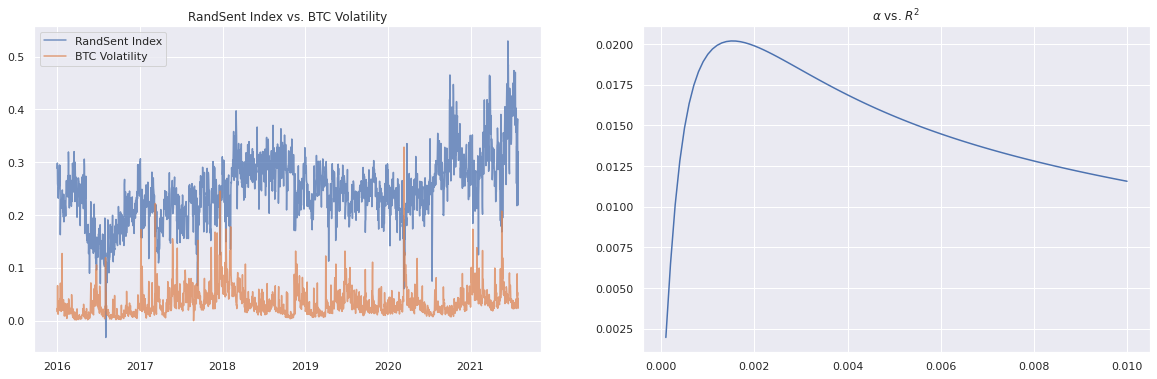

In [7]:
# grid search to find best value of alpha
params = {
    'alpha': np.linspace(1e-4, 1e-2, 100)
}
ewma_search = GridSearch(EWMAModel, params, ewma_eval, higher_is_better=True)
best_params, best_r2 = ewma_search.search(y_val=btc_datasets['train'], 
                                          x_val=randsent_datasets['train'])

print('RandSent Index')
print('Best alpha: {:.5f} | Best R^2: {:.5f}'.format(best_params['alpha'], best_r2))

randsent_model = EWMAModel(**best_params)

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

randsent_index = randsent_model.predict(x=randsent_data).resample('D').last()

ax[0].plot(randsent_index, label='RandSent Index', alpha=0.75)
ax[0].plot(btc_vol, label='BTC Volatility', alpha=0.75)
ax[0].set_title('RandSent Index vs. BTC Volatility')
ax[0].legend(loc='upper left')

ax[1].plot(params['alpha'], ewma_search.scores)
ax[1].set_title(r'$\alpha$ vs. $R^2$')

plt.show()

Sent100 Index
Best alpha: 0.00060 | Best R^2: 0.04975


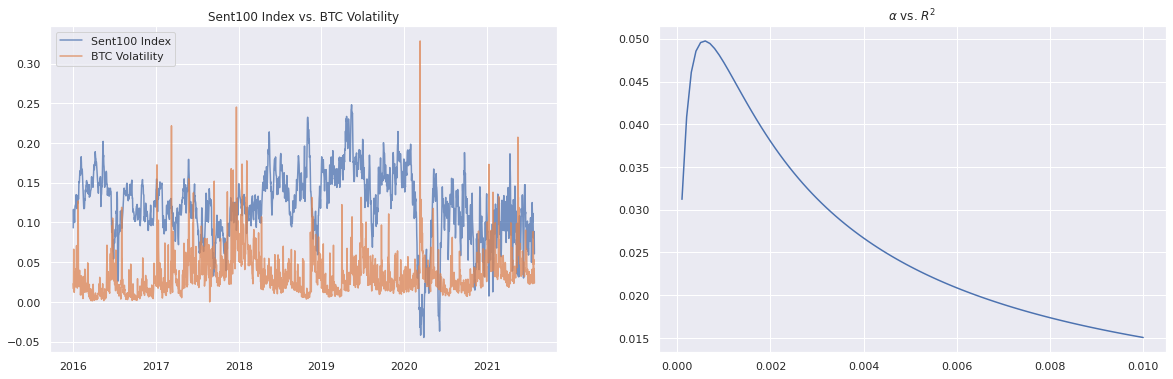

In [8]:
# grid search to find best value of alpha
params = {
    'alpha': np.linspace(1e-4, 1e-2, 100)
}
ewma_search = GridSearch(EWMAModel, params, ewma_eval, higher_is_better=True)
best_params, best_r2 = ewma_search.search(y_val=btc_datasets['train'], 
                                          x_val=sent100_datasets['train'])

print('Sent100 Index')
print('Best alpha: {:.5f} | Best R^2: {:.5f}'.format(best_params['alpha'], best_r2))

sent100_model = EWMAModel(**best_params)

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sent100_index = sent100_model.predict(x=sent100_data).resample('D').last()

ax[0].plot(sent100_index, label='Sent100 Index', alpha=0.75)
ax[0].plot(btc_vol, label='BTC Volatility', alpha=0.75)
ax[0].set_title('Sent100 Index vs. BTC Volatility')
ax[0].legend(loc='upper left')

ax[1].plot(params['alpha'], ewma_search.scores)
ax[1].set_title(r'$\alpha$ vs. $R^2$')

plt.show()

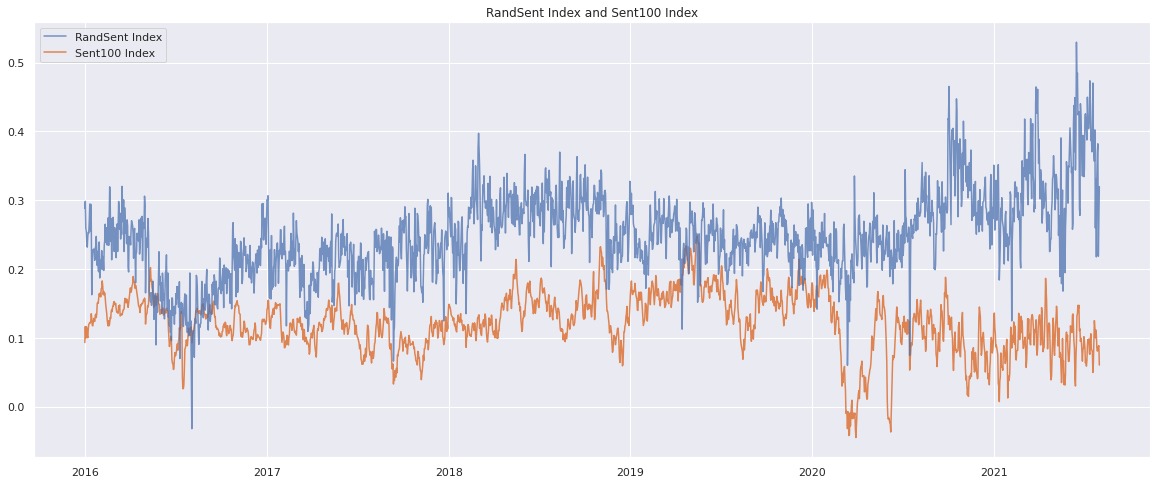

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(randsent_index, label='RandSent Index', alpha=0.75, zorder=2)
ax.plot(sent100_index, label='Sent100 Index', alpha=1.0, zorder=1)
ax.legend(loc='upper left')
ax.set_title('RandSent Index and Sent100 Index')

fig.savefig('sent_indices.png')
plt.show()

The graph above presents our final sentiment indices using the values of $\alpha$ determined via the grid searches above. Below are a couple of outputs used in the report as well.

In [10]:
# summary table used in the report
summary = pd.DataFrame({
    'RandSent Index': randsent_index,
    'Sent100 Index': sent100_index
})
summary = summary.describe()
summary = summary.loc[['mean', '50%', 'std', 'min', 'max'], :]

skew = pd.DataFrame({
    'skew': {'RandSent Index': stats.skew(randsent_index),
             'Sent100 Index': stats.skew(sent100_index)}
}).T
summary = summary.append(skew)

summary.round(4)

,RandSent Index,Sent100 Index
mean,0.2478,0.1222
50%,0.2462,0.1238
std,0.0614,0.0424
min,-0.0319,-0.0448
max,0.5296,0.2482
skew,0.3457,-0.5303


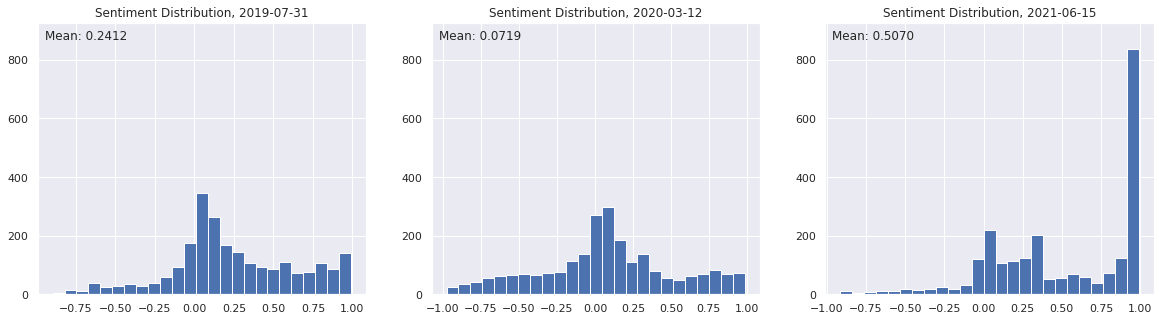

In [11]:
def get_day(df, date):
    """Get data for a single day from a DataFrame."""
    start = pd.to_datetime(date)
    end = start + pd.DateOffset(days=1)

    return df.loc[(df.index >= start) & 
                  (df.index < end)]

# 2020-03-12: 0.16 -> 0.06 (negative move)
# 2021-06-15: 0.39 -> 0.52 (positive move)
# 2019-07-31: 0.22 -> 0.24 (neutral move)
days = ['2019-07-31', '2020-03-12', '2021-06-15']

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, day in enumerate(days):
    tweet_sentiment = get_day(randsent_data, day)
    mean = tweet_sentiment.mean()
    ax[i].hist(tweet_sentiment, bins=25)
    ax[i].set_title('Sentiment Distribution, {}'.format(day))
    ax[i].annotate('Mean: {:.4f}'.format(mean), xy=(7, 255), 
                   xycoords='axes points')

y_max = max([x.get_ylim()[1] for x in ax])
for x in ax:
    x.set_ylim(0, y_max + 50)

# save for report
fig.savefig('sent_distributions.png')
plt.show()

Next, we compile the sentiment indices and other data into a single, comprehensive dataset for our empirical analyses.

In [12]:
# get BTC volatility data
# linearly interpolate the one missing value
btc_vol = data['BTC Realized Vol'].interpolate(method='linear')

# get ETH volatility data
# only linearly interpolate data that is between two valid values
# do NOT interpolate days before first data point
eth_vol = data['ETH Realized Vol'].dropna()
eth_vol = eth_vol.resample('D').asfreq()
eth_vol = eth_vol.interpolate(method='linear')

In [13]:
dataset = pd.DataFrame({
    'btc_vol': btc_vol,
    'eth_vol': eth_vol,
    'randsent_index': randsent_index,
    'sent100_index': sent100_index,
    'btc_return': data['BTC Return'],
    'eth_return': data['BTC Return']
})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2016-01-01 to 2021-07-31
Freq: D
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   btc_vol         2039 non-null   float64
 1   eth_vol         1909 non-null   float64
 2   randsent_index  2039 non-null   float64
 3   sent100_index   2039 non-null   float64
 4   btc_return      2039 non-null   float64
 5   eth_return      2039 non-null   float64
dtypes: float64(6)
memory usage: 176.0 KB


We add tweet count data and VIX data to the dataset as well.

In [14]:
def get_count_data(file, min_date, max_date):
    """Load Twitter tweet count data."""
    df = pd.read_csv(file, index_col='start', parse_dates=['start'])
    df = df[(df.index >= min_date) & (df.index <= max_date)]

    return df.squeeze()

min_date = dataset.index.min()
max_date = dataset.index.max()

crypto_file = os.path.join(COUNT_DIR, 'crypto_tweets_counts.csv')
crypto_tweets = get_count_data(crypto_file, min_date, max_date)

dataset['crypto_tweets'] = crypto_tweets
dataset['ln_crypto_tweets'] = np.log(crypto_tweets)

In [15]:
vix = pd.read_csv(os.path.join(DATA_DIR, 'VIX_history.csv'),
                  index_col=0, parse_dates=['DATE'])
vix = vix.resample('D').interpolate(method='linear')
vix = vix.loc[(vix.index >= min_date) & (vix.index <= max_date), 'CLOSE']

dataset['vix'] = vix / 100

In [16]:
# add the change in sentiment for the day to the dataset
dataset['randsent_index_diff'] = dataset['randsent_index'].diff(1).fillna(0)
dataset['sent100_index_diff'] = dataset['sent100_index'].diff(1).fillna(0)

Again, we split the data between in-sample training data and out-of-sample test data.

In [17]:
# flag days with the train/test split
# same splits as above
train_test_splits = {
    'train': ('2016-01-01', '2020-08-01'),
    'test': ('2020-08-01', '2021-08-01')
}

dataset['set'] = 'train'
dataset.loc[(dataset.index >= train_test_splits['test'][0]) &
            (dataset.index <= train_test_splits['test'][1]), 'set'] = 'test'

dataset['set'].value_counts()

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2016-01-01 to 2021-07-31
Freq: D
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   btc_vol              2039 non-null   float64
 1   eth_vol              1909 non-null   float64
 2   randsent_index       2039 non-null   float64
 3   sent100_index        2039 non-null   float64
 4   btc_return           2039 non-null   float64
 5   eth_return           2039 non-null   float64
 6   crypto_tweets        2039 non-null   int64  
 7   ln_crypto_tweets     2039 non-null   float64
 8   vix                  2039 non-null   float64
 9   randsent_index_diff  2039 non-null   float64
 10  sent100_index_diff   2039 non-null   float64
 11  set                  2039 non-null   object 
dtypes: float64(10), int64(1), object(1)
memory usage: 271.6+ KB


We scale certain fields to have mean 0 and standard deviation 1 to improve the interpretability of the regression coefficients (see **Emprirical Analyses** notebook for regressions and further details). The scaling is based on the mean and standard deviation calculated on the *training set only*; however, these values are applied to the entire dataset, including test data so that we do not introduce any look ahead bias.

In [19]:
# create scaled version of the fields
# these fields have mean 0, std 1 so that interpretting coefficients is easier
fields_to_scale = [
    'randsent_index',
    'sent100_index',
    'randsent_index_diff', 
    'sent100_index_diff', 
    'ln_crypto_tweets',
    'vix', 
    'btc_return',
    'eth_return'
]

scaler = StandardScaler()
scaler.fit(dataset.loc[dataset['set'] == 'train', fields_to_scale])

scaled_fields = [field + '_scaled' for field in fields_to_scale]
dataset[scaled_fields] = scaler.transform(dataset.loc[:, fields_to_scale])

Finally, we save the dataset.

In [20]:
# set the index frequency - this avoids some annoying statsmodels warnings
dataset = dataset.asfreq('D')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2016-01-01 to 2021-07-31
Freq: D
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   btc_vol                     2039 non-null   float64
 1   eth_vol                     1909 non-null   float64
 2   randsent_index              2039 non-null   float64
 3   sent100_index               2039 non-null   float64
 4   btc_return                  2039 non-null   float64
 5   eth_return                  2039 non-null   float64
 6   crypto_tweets               2039 non-null   int64  
 7   ln_crypto_tweets            2039 non-null   float64
 8   vix                         2039 non-null   float64
 9   randsent_index_diff         2039 non-null   float64
 10  sent100_index_diff          2039 non-null   float64
 11  set                         2039 non-null   object 
 12  randsent_index_scaled       2039 non-null   float64
 13  sent100

In [22]:
dataset.to_csv(os.path.join(OUTPUT_DIR, 'empirical_tests_dataset.csv'))